# Coalescent simulations
Following https://tskit.dev/tutorials/no_mutations.html

In [1]:
import msprime

Set up simulation parameters:

In [2]:
L = 1_000_000 # genome size
rho = mu = 1e-8 # recombiation rate and mutation rate
n_subpops = 2
subpop_size = 1e4
migration_rate = 1e-4

One ARG without motations

In [3]:
# simulate ancestry (tree sequence = ARG) without mutations
ts_no_mut = msprime.sim_ancestry(
    samples={f"pop_{i}": 10 for i in range(n_subpops)},
    demography=msprime.Demography.island_model([subpop_size] * n_subpops, migration_rate),
    ploidy=2,
    recombination_rate=rho,
    sequence_length=L,
    random_seed=123
    
)

In [4]:
ts_no_mut

The same RG with mutations added:

In [5]:
ts_mutated = msprime.sim_mutations(
    ts_no_mut,
    rate=mu,
    random_seed=456
)

In [58]:
ts_mutated

The presence of mutation makes the TS object 50% bigger.

## Analysing patterns of relatedness
Based in mutations (as one would do starting vrom a VCF file) and for comparison from trees:

In [6]:
import numpy as np

Divergence based on (weighted) average branch langths:

In [11]:
np.random.seed(10)
sample_a = np.random.choice(ts_no_mut.samples(population=0), size=1)[0]
sample_b = np.random.choice(ts_no_mut.samples(population=1), size=1)[0]

av_tMRCA = 0

for tree in ts_no_mut.trees():
    # get tMRCA and weight by each tree's span
    av_tMRCA += tree.tmrca(sample_a, sample_b) * tree.span /ts_no_mut.sequence_length

print(f"Avg. tMRCA between sample {sample_a} (pop_0) and",
     f"{sample_b} (pop_1) is {av_tMRCA:.2f} {ts_no_mut.time_units}")

Avg. tMRCA between sample 9 (pop_0) and 24 (pop_1) is 42396.75 generations


Based on SNPs:

In [8]:
print(
    f"Genetic divergence between samples {sample_a} and {sample_b} is",
    f"{ts_mutated.divergence([[sample_a], [sample_b]]):.6f}"
)

Genetic divergence between samples 9 and 24 is 0.000840


In [9]:
ab_dist = ts_no_mut.divergence([[sample_a], [sample_b]], mode="branch")

In [10]:
ab_dist

84793.5015739319

Multiplying the branch length by the mutation rate, we get a value very similar to the SNP divergence estimate:

In [74]:
f"{ab_dist * mu:.6f}"

'0.000848'

## Compare $F_{ST}$ estimates based on SNPs and branches

Load plotting library

In [12]:
import matplotlib.pyplot as plt

Make a list of 20 replicate simulations:

In [14]:
n_reps = 20

ts_reps = list(msprime.sim_ancestry(
    samples={f"pop_{i}": 10 for i in range(n_subpops)},
    demography=msprime.Demography.island_model([subpop_size] * n_subpops, migration_rate),
    ploidy=2,
    recombination_rate=rho,
    sequence_length=L,
    random_seed=123,
    num_replicates=n_reps
)
)

A little detour... demonstrate `enumerate()` and `zip()`.

In [15]:
ll = ["a","b","c"]

In [16]:
for k, i in enumerate(ll):
    print(f"Element {k} is {i}")

Element 0 is a
Element 1 is b
Element 2 is c


In [17]:
for k, i, in zip(["a", "b", "c"], ["3", "2", "1"]):
     print(f"List1: {k}, list2: {i}")

List1: a, list2: 3
List1: b, list2: 2
List1: c, list2: 1


Back to our ARGs... add muations to the 20 replicate ARGS:

In [23]:
ts_mutated_reps = [
    msprime.sim_mutations(ts, rate=mu/100, random_seed=i+4)
    for i, ts in enumerate(ts_reps)
]

Get ready to compute $F_{ST}$

In [24]:
def sample_sets(ts):
    return [ts.samples(population=p.id) for p in ts.populations()]

In [25]:
sample_sets(ts_reps[0])

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int32),
 array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39], dtype=int32)]

In [26]:
Fst_genealogy = np.array([ts.Fst(sample_sets(ts), mode="branch") for ts in ts_reps])

In [27]:
Fst_genetic_var = np.array([ts.Fst(sample_sets(ts)) for ts in ts_mutated_reps])

In [28]:
Fst_genetic_var

array([0.04083347, 0.12845075, 0.0931933 , 0.11172998, 0.11784762,
       0.0802867 , 0.01217146, 0.0474748 , 0.0677836 , 0.04174238,
       0.05261433, 0.10640619, 0.0461887 , 0.05188515, 0.09648855,
       0.04368489, 0.05771106, 0.01782587, 0.11527371, 0.02899626])

For the theoretical expectation see e.g. Crow and Aoki (1984) PNAS 81: 6073, eqn 7

In [29]:
Fst_theory = 1/(4*subpop_size*migration_rate*(n_subpops/(n_subpops-1))**2 + 1)

Plot the estimates and theoretical exprectation:

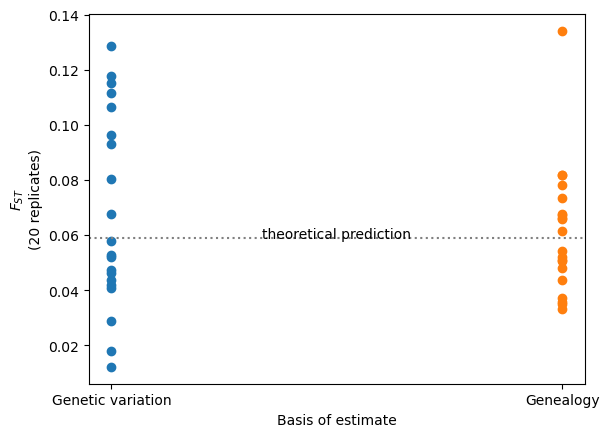

In [30]:
plt.scatter(["Genetic variation"] * 20, Fst_genetic_var)
plt.scatter(["Genealogy"] * 20, Fst_genealogy)
plt.xlabel("Basis of estimate")
plt.ylabel("$F_{ST}$\n(20 replicates)")
plt.axhline(y=Fst_theory, ls=":", c="grey")
plt.text(0.5, Fst_theory, "theoretical prediction", ha="center")
plt.show()

Compare variances. To one of the branch-based estimates is lower:

In [31]:
np.var(Fst_genealogy), np.var(Fst_genetic_var)

(0.000514027107432661, 0.0012015996757774687)

## Distribution of coalescence times for a sample of 2 haploids

In [32]:
tsList = list(msprime.sim_ancestry(
    2,
    ploidy=1,
    population_size=10_000,
    num_replicates=10_000
))

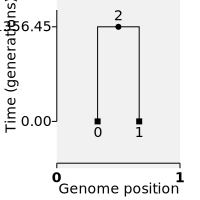

In [33]:
tsList[0].draw_svg(y_axis=True)

In [34]:
tList = [i.first().tmrca(0, 1) for i in tsList]

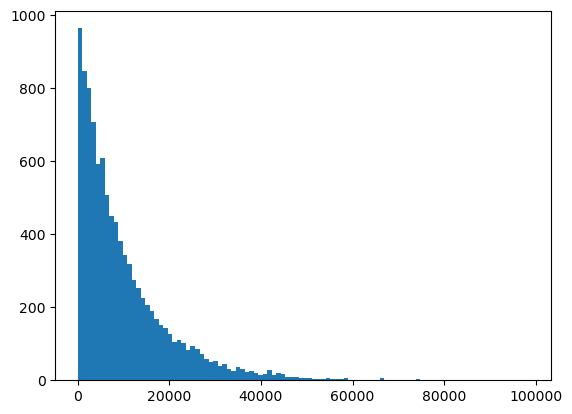

In [35]:
plt.hist(tList, bins=100)
plt.show()